In [1]:
#Required Installs
#!pip install fivecentplots # will need to remove for submission

In [2]:
#Standard Imports
import os

#Third Party Imports
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score
import xgboost as xgb
#import fivecentplots as fcp #clean data vis library for easy pandas integration | will need to remove for submission
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
from sklearn.pipeline import Pipeline
import seaborn as sns
from tqdm import tqdm
from sklearn.model_selection import cross_val_score, KFold, train_test_split, GridSearchCV


In [3]:
train_raw = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv',index_col='Id')
test_raw = pd.read_csv('/kaggle/input/icr-identify-age-related-conditions/test.csv',index_col='Id')

#confirm data
train_raw.head()

,AB,AF,AH,AM,AR,AX,AY,AZ,BC,BD,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
Id,,,,,,,,,,,,,,,,,,,,,
000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,4126.58731,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,5496.92824,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,5135.78024,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,4169.67738,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,5728.73412,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
#fcp.hist(df=train_raw, x='AB', kde=True, kde_width=2)

In [5]:
#Seperate out our target feature
X = train_raw.iloc[:, :-1]
y = train_raw.iloc[:, -1]

#Now is a good time to confirm a few things about our data:
# 1: lets check how our encoding looks and we can decide if we need a new approach
# 2: lets check the distribution of our target feature

print("Categorical spread for EJ:\n", X.EJ.value_counts())
print("istribution of target:\n", y.value_counts())

#Add encoding for our only categorical col
encoder = LabelEncoder()
X.EJ = encoder.fit_transform(X.EJ)

#Now we'll generate our prediction CSV
X_val = test_raw
encoder = LabelEncoder()
X_val.EJ = encoder.fit_transform(X_val.EJ)

Categorical spread for EJ:
 B    395
A    222
Name: EJ, dtype: int64
istribution of target:
 0    509
1    108
Name: Class, dtype: int64


In [6]:
#testing new pipeline and trying to assess shapley values ~
xgb_params=  {'learning_rate': 0.005,
                'objective': 'multi:softprob',
                'num_class': 2,
                'eval_metric': 'auc',
                'tree_method': 'gpu_hist',
                'predictor': 'gpu_predictor',
                'gpu_id': 0,
                'max_bin': 623,
                'max_depth': 10,
                'alpha': 0.5108154566815425,
                'gamma': 1.9276236172849432,
                'reg_lambda': 11.40999855634382,
                'colsample_bytree': 0.705851334291963,
                'subsample': 0.8386116751473301,
                'min_child_weight': 2.5517043283716605,
             }

train_oof = np.zeros((X[X.columns].shape[0],))
test_preds = 0
train_oof_shap = np.zeros((X[X.columns].shape[0], X[X.columns].shape[1]+1))
test_preds_shap = 0
train_oof_shap.shape

weights = np.zeros(len(y))

#finally we want to convert our  testdata to an xgb.Dmatrix
val_index = X_val.index
X_val = xgb.DMatrix(X_val)

In [7]:
%%time

NUM_FOLDS = 5
kf = KFold(n_splits=NUM_FOLDS, shuffle=True, random_state=0)

for f, (train_ind, val_ind) in tqdm(enumerate(kf.split(X, y))):
        #print(f'Fold {f}')
        train_df, val_df = X.iloc[train_ind][X.columns], X.iloc[val_ind][X.columns]
        train_target, val_target = y[train_ind], y[val_ind]
        
        weights = np.zeros(len(train_target))

        # 0 is the majority class in this case by a fair ammount
        weights[train_target == 0] = 1
        weights[train_target == 1] = sum(train_target == 0) / sum(train_target == 1)
        
        train_df = xgb.DMatrix(train_df, label=train_target, weight=weights)
        val_df = xgb.DMatrix(val_df, label=val_target)
        
        model = xgb.train(xgb_params, train_df)
        temp_oof = model.predict(val_df)[:,1]
        temp_oof_shap = model.predict(val_df, pred_contribs=True)[:,1]
        temp_test = model.predict(X_val)[:,1]
        temp_test_shap = model.predict(X_val, pred_contribs=True)[:,1]

        train_oof[val_ind] = temp_oof
        test_preds += temp_test/NUM_FOLDS
        
        train_oof_shap[val_ind, :] = temp_oof_shap
        test_preds_shap += temp_test_shap/NUM_FOLDS
        
        
        print(roc_auc_score(val_target, temp_oof))
        
print(roc_auc_score(y, train_oof))

3it [00:00,  3.98it/s]

0.9512578616352201
0.893048128342246
0.9212421242124212
0.9342857142857144


5it [00:01,  4.77it/s]

0.9696545284780578
0.9316743069198864
CPU times: user 715 ms, sys: 282 ms, total: 996 ms
Wall time: 1.06 s


In [8]:
#now that we have assessed the model we want to train it on all of our availible data:
weights = np.zeros(len(y))

# 0 is the majority class in this case by a fair ammount
weights[y == 0] = 1
weights[y == 1] = sum(y == 0) / sum(y == 1)

train_df = xgb.DMatrix(X, label=y, weight=weights)
model = xgb.train(xgb_params, train_df)

In [9]:
y_preds = model.predict(X_val, output_margin=False)
probs = np.exp(y_preds) / np.sum(np.exp(y_preds), axis=1, keepdims=True)

submission = pd.DataFrame()
submission["Id"] = val_index

submission["class_0"] = probs[:,0]
submission["class_1"] = probs[:,1]


In [10]:
submission.head()

,Id,class_0,class_1
0,00eed32682bb,0.506383,0.493617
1,010ebe33f668,0.506383,0.493617
2,02fa521e1838,0.506383,0.493617
3,040e15f562a2,0.506383,0.493617
4,046e85c7cc7f,0.506383,0.493617


In [11]:
submission.to_csv("submission.csv",header=True,index=False)

`
%%time
#simple testing ~
pipeline = Pipeline([
    ('xgb', XGBClassifier(eval_metric='aucpr', scale_pos_weight = ratio))
])

# Specify the hyperparameters and their values
param_grid = {
    'xgb__n_estimators': [50, 100, 150],
    'xgb__max_depth': [2, 4, 6],
    'xgb__learning_rate': [0.01, 0.1, 0.2]
}

# Create a KFold object
kf = KFold(n_splits=5, random_state=42, shuffle=True)

# Create a GridSearchCV object
grid_search = GridSearchCV(pipeline, param_grid, cv=kf, scoring='roc_auc')

# Fit the GridSearchCV object to the data
grid_search.fit(X, y)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_:.2f}")
`

In [12]:
np.save('train_oof', train_oof)
np.save('test_preds', test_preds)
np.save('train_oof_shap', train_oof_shap)
np.save('test_preds_shap', test_preds_shap)

In [13]:
%matplotlib inline
import cudf, cuml
import cupy as cp

from cuml.manifold import TSNE, UMAP
import matplotlib.pyplot as plt
from matplotlib.pyplot import ylim, xlim

In [14]:
train_df = cudf.read_csv('/kaggle/input/icr-identify-age-related-conditions/train.csv')
train_df.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [15]:
train = cp.load('/kaggle/working/train_oof_shap.npy')
test = cp.load('/kaggle/working/test_preds_shap.npy')

In [16]:
train_test = cp.vstack([train, test])
train_test.shape

(622, 57)

In [17]:
%%time
tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(train_test)

/opt/conda/lib/python3.10/site-packages/cuml/internals/api_decorators.py:344: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return func(**kwargs)


CPU times: user 12 s, sys: 304 ms, total: 12.3 s
Wall time: 13.3 s


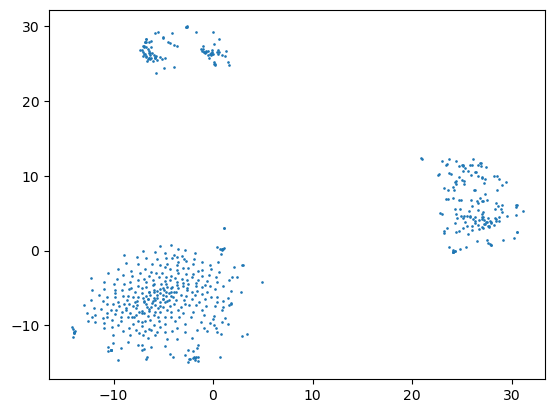

In [18]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), s = 0.8)

In [19]:
%%time
tsne = TSNE(n_components=2)
train_2D = tsne.fit_transform(train)

CPU times: user 336 ms, sys: 13.1 ms, total: 349 ms
Wall time: 346 ms


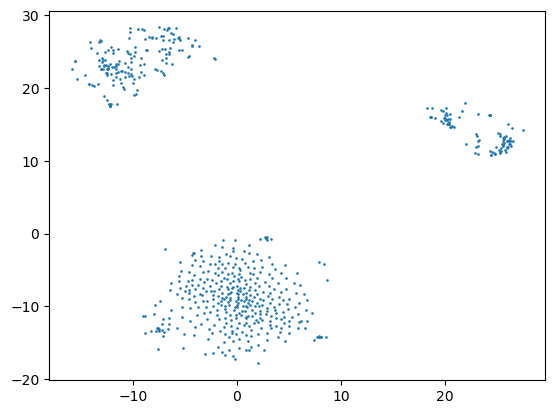

In [20]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), s = 0.8)

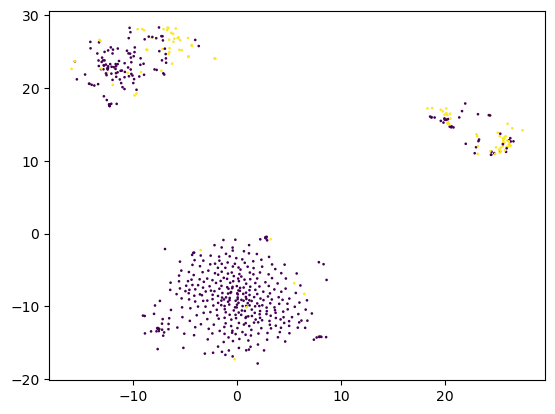

In [21]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), c=train_df['Class'].values.get(), s = 0.8)

In [22]:
%%time
umap = UMAP(n_components=2)
train_2D = umap.fit_transform(train)

CPU times: user 896 ms, sys: 129 ms, total: 1.02 s
Wall time: 1.53 s


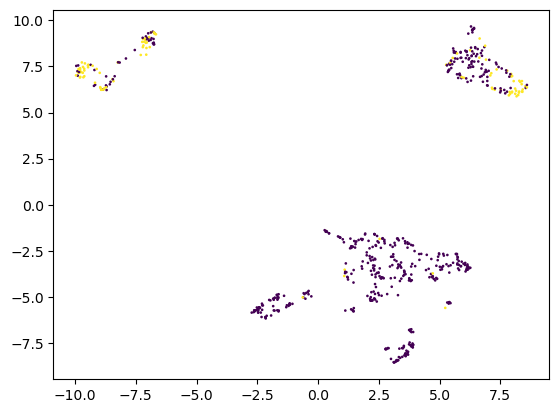

In [23]:
plt.scatter(train_2D[:,0].get(), train_2D[:,1].get(), c=train_df['Class'].values.get(), s = 0.8)